# This notebook is to explore if Ohmnet preserves the relationship of the nodes in the subnetwork like the original network

In [1]:
import sys
sys.path.append("../..")
import platform
import pandas as pd
import numpy as np
import os
import networkx as nx
from src.embedding.network_embedding import *
from src.eda.eda_functions import jaccard_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances as ed
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Prepare data for Ohmnet

In [4]:
subnet1 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\subnetworks_Jan_14\deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv', index_col = 0)

In [8]:
# convert df from adjacency to edgelist
subnet1.values[tuple([np.arange(len(subnet1))]*2)] = np.nan
subnet1_edge = subnet1.stack().reset_index()

In [9]:
le = LabelEncoder()
le.fit(subnet1.columns)
subnet1_edge.level_0 = le.transform(subnet1_edge.level_0) # convert gene id to number to work with Ohmnet
subnet1_edge.level_1 = le.transform(subnet1_edge.level_1)

LabelEncoder()

In [356]:
subnet1_edge = subnet1_edge[subnet1_edge['level_0'].isin([2627, 2999, 2319])] # take only 3 source genes

In [169]:
subnet1_edge = subnet1_edge[subnet1_edge[0] > 0.012] # and subset with weight > 0.012
subnet1_edge.to_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv', index = 0)

In [2]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')

In [ ]:
# Then subnet1_edge is split into 2 dataframes with 12 genes + edges (source and target are the same) overlap 
# The 2 dataframes are then fed to Ohmnet to embed

In [320]:
# edge1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
# edge2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)

In [324]:
## check how many nodes overlap betwen these two sub-subnetwork
# len(set(edge1[1]).intersection(edge2[1]))

258

# Embed the original network and see how strong the jaccard is 

In [2]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')
subnet1_edge.columns = ['source', 'target', 'weight']

In [5]:
subnet1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_edge, source = 'source', target = 'target',
                                                   edge_attr = 'weight')

In [6]:
subnet1_emb = network_embedding(subnet1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1')

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


embedding data saved


In [7]:
subnet1_sub1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
subnet1_sub2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)
subnet1_sub1.columns = ['source', 'target', 'weight']
subnet1_sub2.columns = ['source', 'target', 'weight']

In [8]:
subnet1_sub1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub1, source = 'source', target = 'target',
                                                        edge_attr = 'weight')
subnet1_sub2_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub2, source = 'source', target = 'target',
                                                        edge_attr = 'weight')

In [9]:
subnet1_sub1_emb = network_embedding(subnet1_sub1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub1')
subnet1_sub2_emb = network_embedding(subnet1_sub2_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub2')

Computing transition probabilities:  18%|███████▋                                    | 74/421 [00:00<00:00, 732.74it/s]

embedding data saved


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


embedding data saved


# Compare closest genes for each embedding to the original network by jaccard

In [3]:
def get_closest_genes_jaccard(network, emb, top_n, title):
    ed_data = ed(emb, emb)
    ed_df = pd.DataFrame(ed_data, index = emb.index, columns = emb.index)
    closest_genes1 = [] # find closest genes in the subnetwork
    closest_genes2 = [] # find closest genes in the embedding
    for gene in network.source.unique():
        closest_genes1.append(network[network.source == gene].sort_values('weight', ascending = False)['target'][:top_n])
        top_n_genes = ed_df[gene].sort_values()[1:top_n+1].index
        closest_genes2.append(top_n_genes)
    jac_list = []
    for i in range(len(closest_genes1)):
        jac_list.append(jaccard_similarity(closest_genes1[i], closest_genes2[i]))
#     xticks = le.inverse_transform(subnet1_edge.source.unique())
    plt.rcParams.update({'font.size':18})
    plt.bar(network.source.unique().astype(str), jac_list)
    plt.ylim(0, 1)
    plt.ylabel('Jaccard similarity')
    plt.xlabel('gene')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(title)
    plt.show()
    plt.close()

In [5]:
subnet1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1.csv', index_col = 0)

In [7]:
subnet1_sub1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub1.csv', index_col = 0)
subnet1_sub2_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub2.csv', index_col = 0)

In [8]:
# ohmnet output (embedding)
ohmnet_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\tmp\internal_vectors.emb', sep = ' ', skiprows=1, header = None, index_col = 0)

In [9]:
ohmnet_index = list(ohmnet_emb.index)
new_index = list(map(lambda x:int(x.split('__')[1]), ohmnet_index))
ohmnet_emb.index = new_index

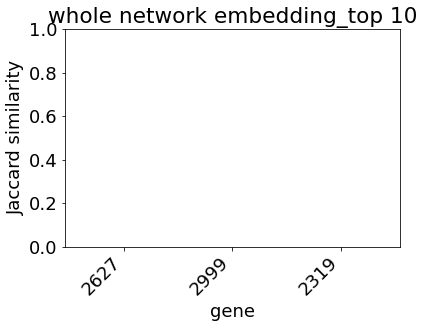

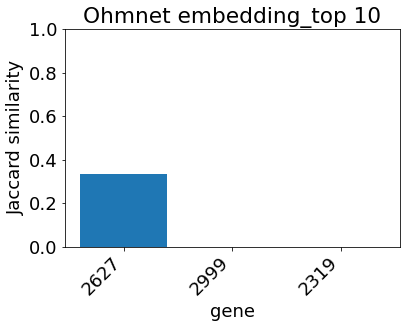

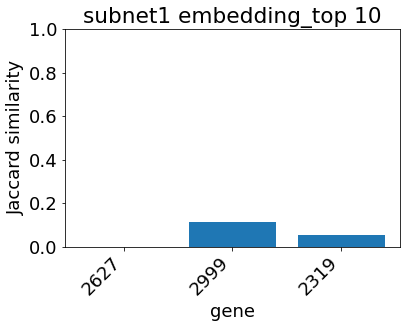

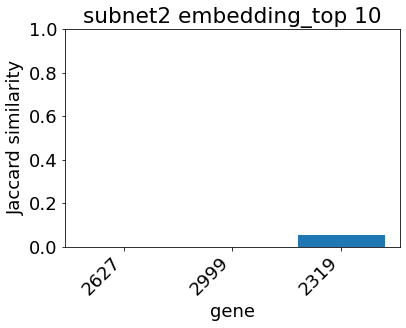

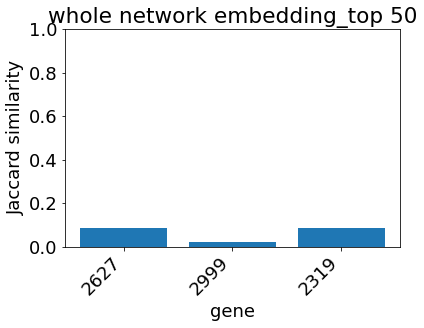

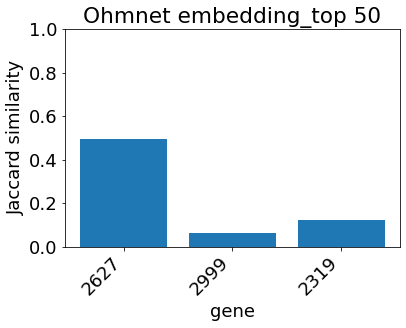

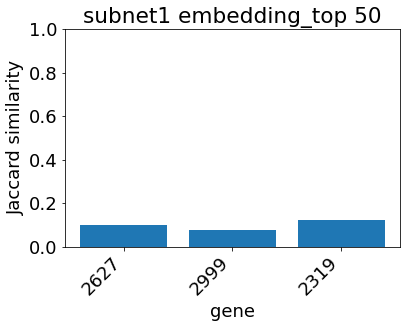

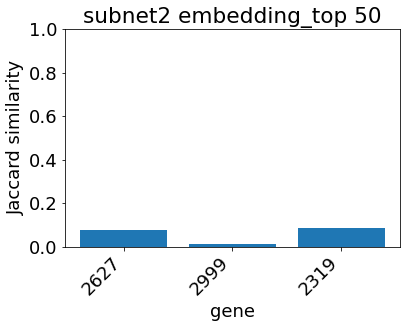

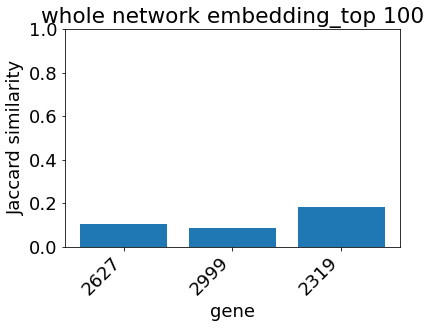

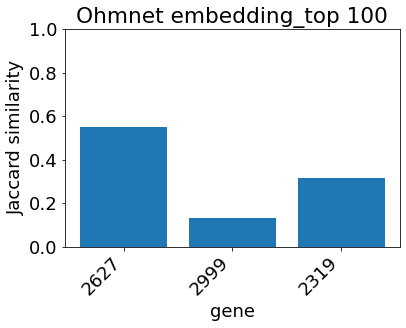

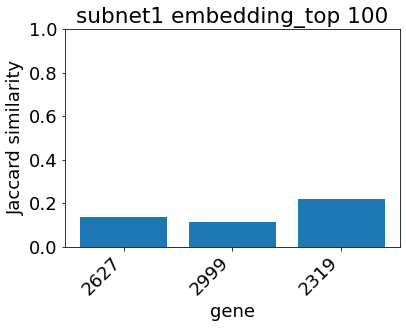

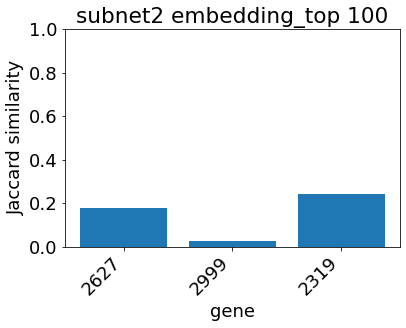

In [10]:
emb_list = [subnet1_emb, ohmnet_emb, subnet1_sub1_emb, subnet1_sub2_emb]
emb_names = ['whole network embedding', 'Ohmnet embedding', 'subnet1 embedding', 'subnet2 embedding']
for n in [10, 50, 100]:
    for i in range(len(emb_list)):
        get_closest_genes_jaccard(subnet1_edge, emb_list[i], n, f'{emb_names[i]}_top {n}')